In [21]:
!pip install emojihunt --upgrade --q
print("Current project version:")
!pip freeze | grep emojihunt
from emojihunt import *
import json
import matplotlib.pyplot as plt
import cv2

from google.colab.patches import cv2_imshow
import numpy as np

Current project version:
emojihunt==1.1.1


# Template For EmojiHunt Project!

## EmojiHunt()
This is your emojihunt environment class you will use it for generating problem images, testing your configuration and getting your final scores on the trials.
### EmojiHunt.get_config()
This returns the dictionary of the configuration for the EmojiHunt. You can change the booleans in this dictionary to make the problem harder or easier.
### EmojiHunt.update_config(dict)
This writes the passed dictionary as the new configuration for the EmojiHunt. It should be formated as recived from .get_config(). 
### EmojiHunt.generate_image_and_points()
This returns 3 objects the target image, the example emoji and the ground truth real points. This function is avalible so you can test your method without needing to perform full official tests. The emoji image and the test target image are simple cv2 formated color images (BGR, numpy uint8). The ground truth points are a list of tuples of points [(x_0,y_0)..(x_n,y_n)]
### EmojiHunt.generate_image_and_points(ground_truth, predicted)
This function gives the score between two sets of emoji points, the ground truth given by .generate_image_and_points() and the prediction points. 
### EmojiHunt.offical_test(function, config)
For this function you explicitly give a callable object (either fucntion or class method) that takes in the positional arguments of image, sample_emoji. This function then runs multiple tests on this function and prints a report based on the config and the socres. Official tests are seeded so the test for each config is always the same. 
### Examples of the usage of all these methods are given below.


In [22]:
emoji_hunt_object = EmojiHunt() 
transforms = {
  "emoji_transforms": {
    "Add": False,
    "Multiply": False,
    "Cutout": False,
    "CoarseDropout": False,
    "CoarseSaltAndPepper": False,
    "JpegCompression": False,
    "BlendAlpha": False,
    "BlendAlphaRegularGrid": False,
    "GaussianBlur": True,
    "MotionBlur": False,
    "MultiplyHueAndSaturation": False,
    "Grayscale": False,
    "ChangeColorTemperature": False,
    "SigmoidContrast": False,
    "CLAHE": False,
    "Emboss": False,
    "DirectedEdgeDetect": False,
    "Fliplr": False,
    "PiecewiseAffine": False,
    "PerspectiveTransform": False,
    "WithPolarWarping": False,
    "Rot90": False,
    "ElasticTransformation": False,
    "Jigsaw": False
  }
}
emoji_hunt_object.update_config(transforms)

def test_bad_function(image, emoji):
    return [(random.randint(0,512),random.randint(0,512))]
emoji_hunt_object.offical_test(test_bad_function,emoji_hunt_object.get_config())

~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     GaussianBlur
Scores (lower is better)....
    Run 0 -> 447.3393808356168
    Run 1 -> 460.5280934303668
    Run 2 -> 459.0573787580963
    Run 3 -> 446.21748216357867
    Run 4 -> 461.6062257748299
    Run 5 -> 454.05831040802633
    Run 6 -> 472.44001718211786
    Run 7 -> 467.3
    Run 8 -> 464.7752231618064
    Run 9 -> 437.6007142766037
    Run 10 -> 447.92280500728987
    Run 11 -> 469.6899314199008
    Run 12 -> 467.72892488052804
    Run 13 -> 440.98470965295047
    Run 14 -> 399.2242477605788
    Run 15 -> 415.21085961087516
    Run 16 -> 355.35316056320875
    Run 17 -> 468.4897077822013
    Run 18 -> 432.0223103180739
    Run 19 -> 250.01799935204664
    Run 20 -> 452.80416646574724
    Run 21 -> 464.27131099154195
    Run 22 -> 405.4694732580626
    Run 23 -> 342.7438758645243
    Run 24 -> 468.8653580205717
    Run 25 -> 392.33442264631867
    Run 26 -> 447.5991510268982
    Run 27 -> 396.6003618806005
    Run 28 -> 41

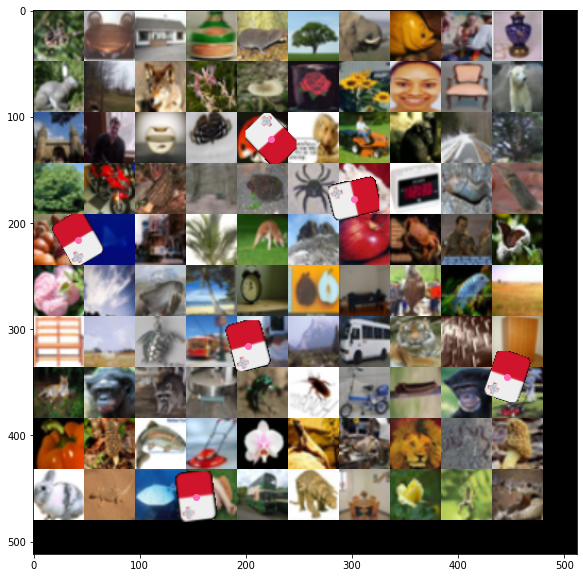

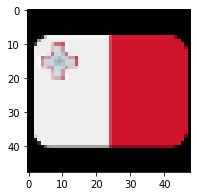

In [27]:
test_image, emoji_target, gt_points = emoji_hunt_object.generate_image_and_points()

plt.figure(figsize = (10,10))
imgplot = plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
x = [p[0] for p in gt_points]
y = [p[1] for p in gt_points]
plt.scatter(y, x, color="hotpink")
plt.show()
plt.figure(figsize = (3,3))
imgplot2 = plt.imshow(cv2.cvtColor(emoji_target, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
''' 
Each subimage is 48x48. Excluding the black borders, the entire
image is 480x480, since we have a 10x10 grid of subimages. Including
the black bars, the image is 512x512.
'''
h, w = test_image.shape[:2]
sub_h, sub_w = emoji_target.shape[:2]
window = 6

sub_images = []
for y in range(0, h - sub_h, window):
  for x in range(0, w - sub_w, window):
    sub_image = test_image[y:y+sub_h, x:x+sub_w]
    sub_images.append(sub_image)

In [29]:
def compute_histogram(image):
  gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
  hist_size = 256
  hist_range = (0, 256)
  hist = cv2.calcHist([gray], [0], None, [hist_size], hist_range, accumulate=False)

  return hist 

def plot_histogram(histogram):
  plt.plot(histogram, color="hotpink")
  plt.show()

def similarity_score(histogram1, histogram2):
  hist1_norm = cv2.normalize(histogram1, histogram1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  hist2_norm = cv2.normalize(histogram2, histogram2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  bhattacharyya = cv2.compareHist(hist1_norm, hist2_norm, cv2.HISTCMP_BHATTACHARYYA)

  return bhattacharyya

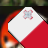

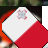

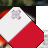

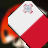

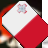

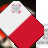

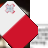

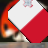

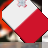

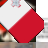

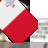

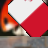

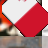

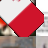

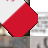

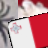

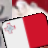

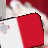

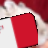

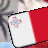

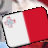

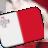

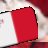

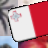

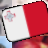

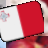

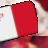

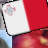

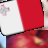

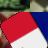

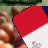

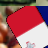

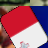

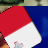

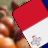

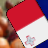

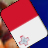

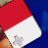

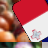

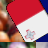

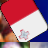

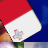

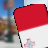

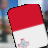

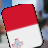

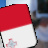

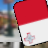

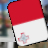

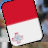

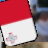

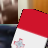

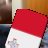

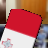

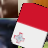

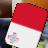

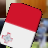

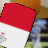

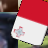

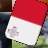

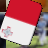

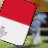

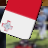

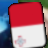

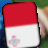

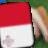

In [39]:
emoji_hist = compute_histogram(emoji_target)
# Remove contribution of pixels with intensity 0
emoji_hist[0] = 0

scores = []
for i in sub_images:
  hist = compute_histogram(i)
  score = similarity_score(emoji_hist, hist)
  scores.append(score)

filtered = []
min_score = min(scores)
for i, score in enumerate(scores):
  # Tolerance will need to be adjusted on a case-by-case basis
  if np.isclose(score, min_score, rtol=0.1):
    filtered.append(sub_images[i])

if len(filtered) < 500:
  for i in filtered:
    cv2_imshow(i)